In [19]:
import mne
from mne.preprocessing import ICA
from mne.decoding import CSP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

<h1 style="color: red; font-weight: bold;">Preprocessing</h1>

## 1.) Loading data

In [20]:
def load_data(subject, session="T"):
    """
    Loads data, includes all channels including EEG and EOG.
    Args:
        subject (int): number of the subject
        session (str):T for training, E for evaluation
    returns: 
        raw (RawGDF): an mne object containing the raw data
        data_raw (list(list(float))): list containing each channel and corresponding data, channel x data samples 
        times (list): list containing each channel and corresponding times, channel x time samples
    """
    
    file_path = f"/Users/kelokomesu/School/COGS 189/final_project/data/A0{subject}{session}.gdf"
    raw = mne.io.read_raw_gdf(file_path, preload=True, eog=["EOG-left", "EOG-central", "EOG-right"])
    data_raw, times = raw.get_data(return_times=True)
    raw.rename_channels({'EEG-Fz': 'EEG-Fz','EEG-0': 'EEG-2','EEG-1': 'EEG-3','EEG-2': 'EEG-4','EEG-3': 'EEG-5','EEG-4': 'EEG-6','EEG-5': 'EEG-7','EEG-C3': 'EEG-C3','EEG-6': 'EEG-9','EEG-Cz': 'EEG-Cz','EEG-7': 'EEG-11','EEG-C4': 'EEG-C4','EEG-8': 'EEG-13','EEG-9': 'EEG-14','EEG-10': 'EEG-15','EEG-11': 'EEG-16','EEG-12': 'EEG-17','EEG-13': 'EEG-18','EEG-14': 'EEG-19','EEG-Pz': 'EEG-Pz','EEG-15': 'EEG-21','EEG-16': 'EEG-22','EOG-left': 'EOG-left','EOG-central': 'EOG-central','EOG-right': 'EOG-right'})

    return raw, data_raw, times

In [21]:
# test subject 1
sub1_raw, sub1_data_raw, sub1_times = load_data(1)

Extracting EDF parameters from /Users/kelokomesu/School/COGS 189/final_project/data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/Users/kelokomesu/anaconda3/envs/mne/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


## 2.) Filter data

In [22]:
def bandpass_filter(raw_data, bands):
    """
    Creates bandpass filters for raw data
    Args:
        raw_data (list(list(floats))): raw data from a single subject
        bands (list(tuples)): bands which need to be created
    Returns:
        filtered_data (list(RawGDF)): returns a list of RawGDF objects, each with their specified bandpass filter
    """

    filtered_data = []
    for band in bands:
        filtered_data.append(raw_data.filter(l_freq=band[0], h_freq=band[1]))
        
    return filtered_data

In [23]:
# a list of RawGDF objects, each with thier own bandpass filter
sub1_filtered_list = bandpass_filter(sub1_raw,[(0,5),(5,40)])

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 5.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


## 3.) Artifact Detection and Removal (if needed)

### Manual Artifact Detection and Removal

In [24]:
def detect_artifact(raw_data, artifact):
    """
    Produces a number of plots to check if the current dataframe has major artifacts
    Args:
        raw_data (RawGDF): RawGDF object
        artifact (string): 'low freq drift'. 'power line noise', 'heartbeat', 'ocular'
    Returns:
        Plot based on specified artifact
    """
    data = raw_data.copy()
    if artifact == "low freq drift":
        return data.plot(duration=60, remove_dc=False, verbose=0) #direct current offset set to False
    elif artifact == "power line noise":
        return data.plot_psd(fmax=100, verbose=0) #
    elif artifact == "eog":
        eog_epochs = mne.preprocessing.create_eog_epochs(data, baseline=(-0.5, -0.2)) #finds eog artifacts and extracts into an Epoch object in one step
        eog_epochs.plot_image(combine="mean")
        # eog_epochs.average().plot_joint()

Using EOG channels: EOG-left, EOG-central, EOG-right
EOG channel index for this subject is: [22 23 24]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG-central for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 16 significant peaks
Number of EOG events detected: 16
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 16 events and 251 original time points ...

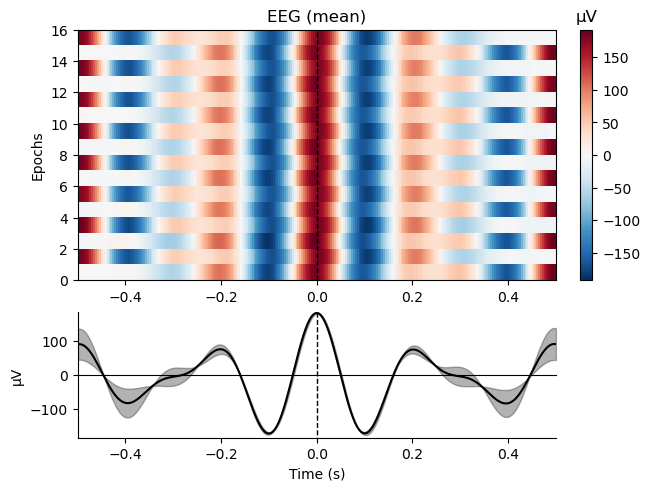

In [25]:
detect_artifact(sub1_filtered_list[1], "eog")

### Automatic Artifact Detection and Removal

In [26]:
def do_ICA(filtered_data, n_components, remove):
    data = filtered_data.copy()
    ica = ICA(n_components=n_components, random_state=97, method="fastica")
    ica.fit(data)
    ecg_idx, ecg_scores = ica.find_bads_ecg(data)
    return ecg_idx, ecg_scores

    # # Automatically detect eye-blink artifacts using EOG channels
    # eog_indices, eog_scores = ica.find_bads_eog(raw)
    # # Plot correlation with EOG signals
    # ica.plot_scores(eog_scores)
    # # Remove detected components
    # if remove:
    #     ica.exclude = eog_indices
    #     # Apply ICA cleaning to EEG data
    #     raw_cleaned = ica.apply(raw)
    #     return raw_cleaned

In [27]:
do_ICA(sub1_filtered_list[0], 20, True)

Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components


KeyboardInterrupt: 

## 4.) Epoching

In [28]:
def create_epoch(filtered_data, min, max):
    """
    Creating epochs from filtered and artifact clean data
    Args:
        filtered_data (RawGDF): gdf object
    Returns:
        epochs (epoch): mne epoch object for this subject and filter
    """

    events = mne.events_from_annotations(filtered_data)

    event_dict = {"rejected trial":1,"eye movements":2,"idling eeg (eyes open)":3,"idling eeg (eyes closed)":4,"new run":5,"start trial":6,"left":7,"right":8,"feet":9,"tongue":10}
    
    epochs = mne.Epochs(
        filtered_data.copy(), # raw filtered data
        events[0], # event array
        tmin=min, # time before event, baseline correction (seconds)
        tmax=max, # time after event (seconds)
        event_repeated="drop", # what to do when multiple events have the same starting time
        preload=True, # preload data into memory for faster processing
        event_id=event_dict # mapping event id to the actual event description
        )
    
    return epochs

In [29]:
sub1_epochs_list = [create_epoch(i, -0.5, 2) for i in sub1_filtered_list]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 626 original time points ...
1 bad epochs dropped
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 626 original time points ...
1 bad epochs dropped


In [30]:
sub1_epochs_list[1].get_data()[0][0].shape

(626,)

<h1 style="color: red; font-weight: bold;">Classification</h1>

# 5.) Feature Extraction

In [31]:
def do_CSP(epoch_data, n_components, labels):
    """
    Extracts spatial features from epoched trails from specified classes. Features are also standardized.
    Args:
        epoch_data (epoch): mne epoch object
    Returns:
        dataset (list(list(int))): dataset as a np array with the last entry in each list as the label

    """
    d = epoch_data.copy()

    epoch_list = []
    for label in labels:
        epoch_list.append(d[label])
    data = mne.concatenate_epochs(epoch_list)

    X = data.pick("eeg").get_data()
    y = data.events[:,-1]

    csp = CSP(n_components=n_components)
    X_csp = csp.fit_transform(X, y)

    dataset = np.hstack((X_csp, y.reshape(-1,1)))
    return dataset


In [32]:
sub1lr_dataset = do_CSP(sub1_epochs_list[1], 6, ["left", "right"])

Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
Computing rank from data with rank=None


/var/folders/ry/vqfl8s7s5l10hspc5lj10xth0000gn/T/ipykernel_28689/1821285707.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list)


    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3e+09  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


# 6.) Creating Training, Validation, and Test Datasets

In [33]:
# normal train, val, test
def create_tvt_datasets(dataset, trainr, valtestr):
    """
    Creating test, validation, and test datasets for classification
    Args:
        epoch_data (epoch): epoch object of a single subject
        trainr, valtestr (float): ratio of splits
        label (list(str)): name of the class we are interested in for this dataset, "left", "right", "feet", "toungue"
    """

    data = dataset.copy()

    # Get the number of epochs
    n_epochs = len(data)
    
    # Generate shuffled indices
    indices = np.arange(n_epochs)
    np.random.shuffle(indices)

    # Compute split points
    train_end = int(n_epochs * trainr)
    val_end = train_end + int(n_epochs * valtestr)

    # Split indices
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Create subsets
    epochs_train = data[train_indices]
    epochs_val = data[val_indices]
    epochs_test = data[test_indices]

    return epochs_train, epochs_val, epochs_test

In [ ]:
def k_fold_cv():
    

In [34]:
sub1lr_train, sub1lr_val, sub1lr_test = create_tvt_datasets(sub1lr_dataset, 0.7, 0.15)

# 7.) Classify

In [ ]:
def LDA_predict(model, test_data, scaler=None):
    """
    Takes in a model and 
    """
    X_test = test_data[:,:-1]
    y_test = test_data[:,-1]

    # scale X test data from a fitted train scaler
    X_test_scaled = scaler.transform(X_test)

    # Predict the labels for test data
    y_pred = model.predict(X_test_scaled)

    return y_pred

In [ ]:
def LDA_fit(train_data, test_data):
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]

    # Scale data for LDA
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Initialize and train LDA classifier
    lda = LinearDiscriminantAnalysis()
    return lda.fit(X_train_scaled, y_train), X_train_scaled


In [36]:
LDA_fit(sub1lr_train, sub1lr_test)

LinearDiscriminantAnalysis()

In [ ]:
LDA_classification(sub1lr_train, sub1lr_test)

<h1 style="color: red; font-weight: bold;">Classification</h1>

In [ ]:
def cross_subject_classification_pipeline(bsub, tsubs, lf, hf, emin, emax, csp_comp,):
    """
    Complete cross subject classification and evaluation
    Args:
        subject_base (int): # of the subject being
        subject_test (list(ints)): list of subjects to test base model against
        lf (int): lower frequency to filter raw data
        hf (int): high frequency to filter raw data

    """
    # base subject load data
    bsub_raw, bsub_data_raw, bsub_times = load_data(subject_base)

    # base subject filter data
    bsub_filtered = bandpass_filter(bsub_raw,[(lf,hf)])

    # base subject epoch data
    bsub_epoch = create_epoch(bsub_filtered, emin, emax)

    # base subject feature extraction 
    bsub_dataset = do_CSP(bsub_epoch, csp_comp, ["left", "right"])

    # base subject create train val, test sets
    bsub_train, bsublr_val, bsub_test = create_tvt_datasets(bsub_dataset, 0.7, 0.15)

    # base subject fit LDA model
    bsub_model, bsub_scaler = LDA_fit(bsub_train, bsub_test)

    # base subject LDA model predictions
    bsub_preds, _ = LDA_predict(bsub_model, bsub_scaler)

    results = []

    bsub_train_y = bsub_train[:,-1]
    # base subject prediction on its own train test split
    bsub_bsub_accuracy = accuracy_score(bsub_train_y, bsub_preds)

    results.append(f"bsub->bsub{bsub_bsub_accuracy}")

    for tsub in tsubs:
        tsub, bsub_data_raw, bsub_times = load_data(subject_base)







In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

Extracting EDF parameters from /Users/kelokomesu/School/COGS 189/final_project/data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


/Users/kelokomesu/anaconda3/envs/mne/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
